# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 5, 5
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block8_10_conv', 'conv_7b']
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8188 - accuracy: 0.7246

947/947 [==============================] - 3652s 4s/step - loss: 0.8188 - accuracy: 0.7246 - val_loss: 3.8797 - val_accuracy: 0.6024
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.7060 - accuracy: 0.7587

947/947 [==============================] - 3348s 4s/step - loss: 0.7060 - accuracy: 0.7587 - val_loss: 0.7321 - val_accuracy: 0.7469
Epoch 3/200
947/947 [==============================] - 3066s 3s/step - loss: 0.6525 - accuracy: 0.7743 - val_loss: 2.2284 - val_accuracy: 0.6178
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6205 - accuracy: 0.7823

947/947 [==============================] - 3347s 4s/step - loss: 0.6205 - accuracy: 0.7823 - val_loss: 0.6821 - val_accuracy: 0.7656
Epoch 5/200
947/947 [==============================] - 3036s 3s/step - loss: 0.5932 - accuracy: 0.7933 - val_loss: 0.8684 - val_accuracy: 0.7550
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.5640 - accuracy: 0.8014

947/947 [==============================] - 3320s 4s/step - loss: 0.5640 - accuracy: 0.8014 - val_loss: 0.6625 - val_accuracy: 0.7666
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5536 - accuracy: 0.8043

947/947 [==============================] - 3390s 4s/step - loss: 0.5536 - accuracy: 0.8043 - val_loss: 0.6224 - val_accuracy: 0.7801
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.5334 - accuracy: 0.8125

947/947 [==============================] - 3304s 3s/step - loss: 0.5334 - accuracy: 0.8125 - val_loss: 0.5758 - val_accuracy: 0.7937
Epoch 9/200
947/947 [==============================] - 3027s 3s/step - loss: 0.5115 - accuracy: 0.8194 - val_loss: 0.6016 - val_accuracy: 0.7863
Epoch 10/200
947/947 [==============================] - 3029s 3s/step - loss: 0.5010 - accuracy: 0.8229 - val_loss: 0.6091 - val_accuracy: 0.7893
Epoch 11/200
947/947 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.8272

947/947 [==============================] - 3323s 4s/step - loss: 0.4831 - accuracy: 0.8272 - val_loss: 0.5317 - val_accuracy: 0.8123
Epoch 12/200
947/947 [==============================] - ETA: 0s - loss: 0.4698 - accuracy: 0.8321

947/947 [==============================] - 3287s 3s/step - loss: 0.4698 - accuracy: 0.8321 - val_loss: 0.5230 - val_accuracy: 0.8168
Epoch 13/200
947/947 [==============================] - 3148s 3s/step - loss: 0.4469 - accuracy: 0.8386 - val_loss: 0.5469 - val_accuracy: 0.8007
Epoch 14/200
947/947 [==============================] - 3073s 3s/step - loss: 0.4318 - accuracy: 0.8451 - val_loss: 0.5390 - val_accuracy: 0.8116
Epoch 15/200
947/947 [==============================] - ETA: 0s - loss: 0.4262 - accuracy: 0.8475

947/947 [==============================] - 3389s 4s/step - loss: 0.4262 - accuracy: 0.8475 - val_loss: 0.5101 - val_accuracy: 0.8189
Epoch 16/200
947/947 [==============================] - ETA: 0s - loss: 0.4051 - accuracy: 0.8537

947/947 [==============================] - 3387s 4s/step - loss: 0.4051 - accuracy: 0.8537 - val_loss: 0.4996 - val_accuracy: 0.8309
Epoch 17/200
947/947 [==============================] - 3056s 3s/step - loss: 0.4044 - accuracy: 0.8536 - val_loss: 0.8146 - val_accuracy: 0.7556
Epoch 18/200
947/947 [==============================] - 3088s 3s/step - loss: 0.3864 - accuracy: 0.8607 - val_loss: 0.5425 - val_accuracy: 0.8116
Epoch 19/200
947/947 [==============================] - 3083s 3s/step - loss: 0.3802 - accuracy: 0.8631 - val_loss: 0.5229 - val_accuracy: 0.8272
Epoch 20/200
947/947 [==============================] - 3157s 3s/step - loss: 0.3599 - accuracy: 0.8688 - val_loss: 0.6440 - val_accuracy: 0.8058
Epoch 21/200
947/947 [==============================] - 3027s 3s/step - loss: 0.3442 - accuracy: 0.8743 - val_loss: 0.6565 - val_accuracy: 0.7926
Epoch 22/200
947/947 [==============================] - 3020s 3s/step - loss: 0.3357 - accuracy: 0.8754 - val_loss: 0.5350 - val_accuracy

947/947 [==============================] - 3538s 4s/step - loss: 0.3304 - accuracy: 0.8823 - val_loss: 0.4912 - val_accuracy: 0.8300
Epoch 24/200
947/947 [==============================] - 3290s 3s/step - loss: 0.3100 - accuracy: 0.8847 - val_loss: 0.5014 - val_accuracy: 0.8315
Epoch 25/200
947/947 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.8897

947/947 [==============================] - 3410s 4s/step - loss: 0.3003 - accuracy: 0.8897 - val_loss: 0.4769 - val_accuracy: 0.8419
Epoch 26/200
947/947 [==============================] - 3042s 3s/step - loss: 0.2933 - accuracy: 0.8915 - val_loss: 0.5288 - val_accuracy: 0.8238
Epoch 27/200
947/947 [==============================] - 3266s 3s/step - loss: 0.2847 - accuracy: 0.8946 - val_loss: 0.5126 - val_accuracy: 0.8291
Epoch 28/200
947/947 [==============================] - 3135s 3s/step - loss: 0.2797 - accuracy: 0.8964 - val_loss: 0.5037 - val_accuracy: 0.8358
Epoch 29/200
947/947 [==============================] - 3206s 3s/step - loss: 0.2618 - accuracy: 0.9044 - val_loss: 0.6152 - val_accuracy: 0.8128
Epoch 30/200
947/947 [==============================] - 3080s 3s/step - loss: 0.2595 - accuracy: 0.9057 - val_loss: 0.5360 - val_accuracy: 0.8304
Epoch 31/200
947/947 [==============================] - 3106s 3s/step - loss: 0.2414 - accuracy: 0.9101 - val_loss: 0.6794 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 317s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9535272513079935,
 'basal cell carcinoma': 0.9881275332432624,
 'dermatofibroma': 0.9748886716628652,
 'melanoma': 0.9376684080285951,
 'nevus': 0.9658702085175661,
 'pigmented benign keratosis': 0.9883920741390344,
 'seborrheic keratosis': 0.9595189502815561,
 'solar lentigo': 0.9688053627005027,
 'squamous cell carcinoma': 0.9806723997042686,
 'vascular lesion': 0.9963614641033997}

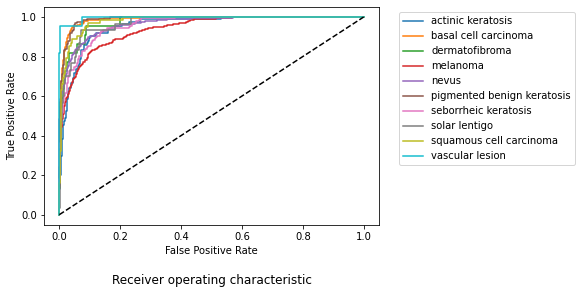

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

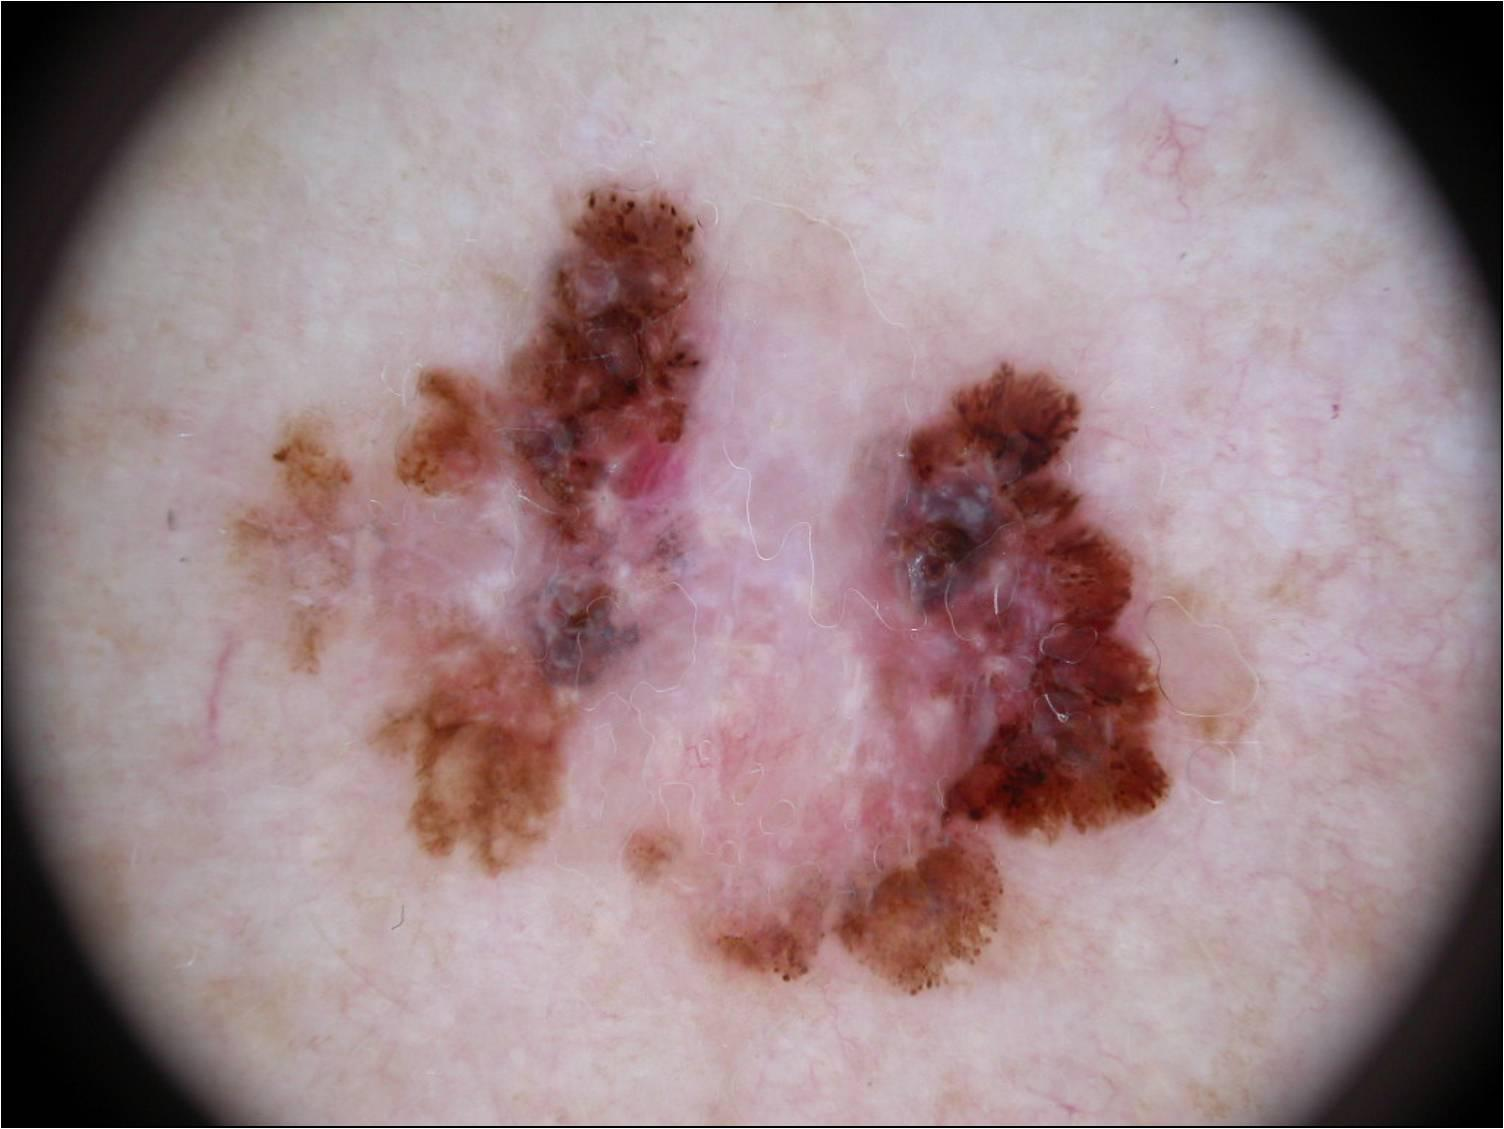

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, RETRAINABLE_LAYERS[-1])

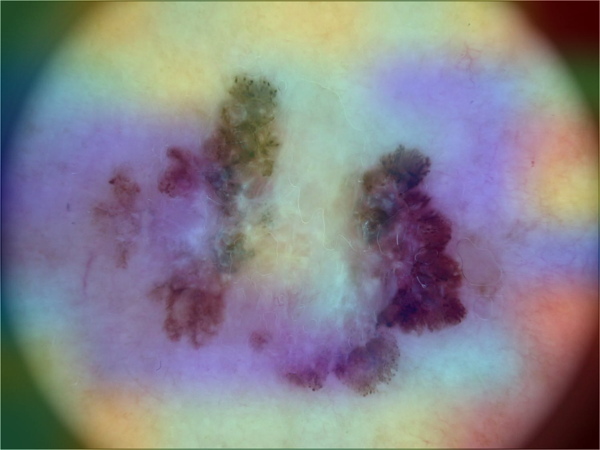

In [23]:
display_gradcam(melanoma_im_path, heatmap)